<a href="https://colab.research.google.com/github/probml/boljax/blob/main/boljax/kalman/demos/mnist_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports and Dataset

In [1]:
try:
    import flax
    import optax
    import ml_collections
    import chex
except ModuleNotFoundError:
    %pip install flax
    %pip install optax
    %pip install ml_collections
    %pip install chex
    import flax 
    import optax
    import ml_collections
    import chex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 189 kB 7.3 MB/s 
     |████████████████████████████████| 8.3 MB 4.8 MB/s 
     |████████████████████████████████| 237 kB 67.5 MB/s 
     |████████████████████████████████| 154 kB 83.1 MB/s 
     |████████████████████████████████| 51 kB 3.2 MB/s 
     |████████████████████████████████| 85 kB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 1.7 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=8bd134e03157aab677d3f4c56f220f6ec979dd040aed7d2525a9e1bca8ae4e20
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collection

In [2]:
try:
    from dynamax.linear_gaussian_ssm.inference import PosteriorGSSMFiltered
    from dynamax.generalized_gaussian_ssm.inference import _condition_on, EKFIntegrals, UKFIntegrals, GHKFIntegrals, conditional_moments_gaussian_filter
    from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install dynamax
    from dynamax.linear_gaussian_ssm.inference import PosteriorGSSMFiltered
    from dynamax.generalized_gaussian_ssm.inference import _condition_on, EKFIntegrals, UKFIntegrals, GHKFIntegrals, conditional_moments_gaussian_filter
    from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM

installing dynamax
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 121 kB 8.3 MB/s 
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1


In [95]:
import gc
from functools import partial
import time
from typing import Callable, Sequence
import collections.abc
import warnings
import copy
from collections import deque

import ml_collections
import tensorflow_datasets as tfds
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalDiag as MVND
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from flax import linen as nn
from flax.training import train_state
import jax
from jax import jit, vmap, lax, jacfwd
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import jax.random as jr
import optax
from sklearn.preprocessing import OneHotEncoder

from dynamax.generalized_gaussian_ssm.dekf.diagonal_inference import (
    DEKFParams,
    _full_covariance_condition_on,
    _stationary_dynamics_diagonal_predict,
    _fully_decoupled_ekf_condition_on,
    stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter,
    _variational_diagonal_ekf_condition_on,
    stationary_dynamics_variational_diagonal_extended_kalman_filter,
    _jacrev_2d,
)
from dynamax.generalized_gaussian_ssm.dekf.optimizer import (
    CMGFOptimizerParams,
    CMGFOptimizer,
    FDEKFOptimizer,
    VDEKFOptimizer,
)

In [4]:
jax.numpy.set_printoptions(suppress = True, precision=4)

In [5]:
def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    train_ds['image'] = jnp.float32(train_ds['image']) / 255.
    test_ds['image'] = jnp.float32(test_ds['image']) / 255.
    return train_ds, test_ds

In [6]:
def get_config(learning_rate=0.01, momentum=2e-1, batch_size=1, num_epochs=1):
    """Get the default hyperparameter configuration."""
    config = ml_collections.ConfigDict()
    config.learning_rate = learning_rate
    config.momentum = momentum
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    return config

In [7]:
train_ds, test_ds = get_datasets()

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# 1. Training Setup

##1.1 CNN and MLP Models

In [8]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

In [9]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

In [10]:
def create_train_state(key, config):
    """Creates initial `TrainState`."""
    cnn = CNN()
    params = cnn.init(key, jnp.ones([1, 28, 28, 1]))['params']
    tx = optax.sgd(config.learning_rate, config.momentum)
    return train_state.TrainState.create(
        apply_fn=cnn.apply, params=params, tx=tx)

In [11]:
def create_train_state_mlp(key, config, features):
    mlp = MLP(features)
    params = mlp.init(key, jnp.ones([1, 28, 28, 1]).ravel())['params']
    tx = optax.sgd(config.learning_rate, config.momentum)
    return train_state.TrainState.create(
        apply_fn=mlp.apply, params=params, tx=tx)

## 1.2 Training Steps - SGD

In [67]:
# SGD Training Steps
@jit
def apply_model_sgd(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, images)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy

@jit
def update_model_sgd(state, grads):
    return state.apply_gradients(grads=grads)

def train_epoch_sgd(state, train_ds, batch_size, result, params_interval, key, polyak_averaging, polyak_window):
    """Train for a single epoch."""
    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(key, len(train_ds['image']))
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = []
    epoch_accuracy = []
    params_history = deque()
    _, unflatten_fn = ravel_pytree(state.params)

    pbar = tqdm(perms, desc=f'loss-scaled mean accuracy: 0; mean accuracy: 0')
    for i, perm in enumerate(pbar):
        batch_images = train_ds['image'][perm, ...]
        batch_labels = train_ds['label'][perm, ...]
        grads, loss, accuracy = apply_model_sgd(state, batch_images, batch_labels)
        state = update_model_sgd(state, grads)
        if polyak_averaging:
            flattened_params, _ = ravel_pytree(state.params)
            params_history.append(flattened_params)
            if len(params_history) == polyak_window+1:
                params_history.popleft()

        if i%params_interval == (params_interval-1):
            if polyak_averaging:
                averaged_params = unflatten_fn(jnp.array(params_history).mean(axis=0))
                result[f'param_per_{params_interval}_batches'].append(averaged_params)
            else:
                result[f'param_per_{params_interval}_batches'].append(state.params)
            message = ('loss-scaled mean accuracy: ' +
                  f'{jnp.exp(-jnp.mean(jnp.array(epoch_loss[i-(params_interval-1):i+1]))):.3f}' +
                  '; mean accuracy: ' + f'{jnp.mean(jnp.array(epoch_accuracy[i-(params_interval-1):i+1])):.3f}')
            pbar.set_description(message)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
    train_loss = jnp.mean(jnp.array(epoch_loss))
    train_accuracy = jnp.mean(jnp.array(epoch_accuracy))
    return state, train_loss, train_accuracy

def train_and_evaluate_sgd(train_ds, config, train_with_MLP=False, features=None, params_interval=600, key=0, polyak_averaging=False, polyak_window=300):
    """Execute model training and evaluation loop.
    """
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jax.random.split(key)

    if train_with_MLP:
        state = create_train_state_mlp(key, config, features)
    else:
        state = create_train_state(key, config)

    result = {f'param_per_{params_interval}_batches': [], 'run_time_per_epoch': []}
    for epoch in range(1, config.num_epochs + 1):
        start = time.time()
        key, subkey = jax.random.split(subkey)
        state, train_loss, train_accuracy = train_epoch_sgd(state, train_ds, config.batch_size,
                                                            result, params_interval, key,
                                                            polyak_averaging, polyak_window)
        result['run_time_per_epoch'].append(time.time() - start)

    return state, result

## 1.3 Evaluation Steps

In [ ]:
@jit
def evaluate_neg_log_likelihood(state, params, test_set):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    @jit
    def evaluate_nll(state, params, label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = state.apply_fn({'params': params}, image).ravel()
        return -jnp.log(jnp.exp(logits[label])/jnp.sum(jnp.exp(logits)))
    nlls = vmap(evaluate_nll, (None, None, 0, 0))(state, params, test_set['label'], test_set['image'])
    return nlls.mean()

@jit
def evaluate_accuracy(state, params, test_set):
    """ Evaluate accuracy given parameters and test state
    """
    @jit
    def misclassification(state, params, label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = state.apply_fn({'params': params}, image).ravel()
        return jnp.where(jnp.argmax(logits) == label, 0, 1)
    miscl = vmap(misclassification, (None, None, 0, 0))(state, params, test_set['label'], test_set['image'])
    return miscl.sum()/len(miscl)

Locally-linearized versions (see https://arxiv.org/pdf/2008.08400.pdf)


In [ ]:
@jit
def evaluate_locally_linearized_neg_log_likelihood(state, params, param_map, test_set):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    flat_params, unflatten_fn = ravel_pytree(params)
    
    @jit
    def evaluate_nll(label, image):
        image = image.reshape((1, 28, 28, 1))
        apply = lambda p: state.apply_fn({'params': unflatten_fn(p)}, image).ravel()
        H = _jacrev_2d(apply, param_map)
        logits = apply(param_map).ravel() + H @ (flat_params - param_map)
        return -jnp.log(jnp.exp(logits[label])/jnp.sum(jnp.exp(logits)))
    nlls = vmap(evaluate_nll, (0, 0))(test_set['label'], test_set['image'])
    return nlls.mean()

@jit
def evaluate_locally_linearized_accuracy(state, params, param_map, test_set):
    """ Evaluate accuracy given parameters and test state
    """
    flat_params, unflatten_fn = ravel_pytree(params)

    @jit
    def misclassification(label, image):
        image = image.reshape((1, 28, 28, 1))
        apply = lambda p: state.apply_fn({'params': unflatten_fn(p)}, image).ravel()
        logits = apply(param_map).ravel() + \
            (_jacrev_2d(apply, param_map) @ (flat_params - param_map)).ravel()
        return jnp.where(jnp.argmax(logits) == label, 0, 1)
    miscl = vmap(misclassification, (0, 0))(test_set['label'], test_set['image'])
    return miscl.sum()/len(miscl)

## 1.4 Training Steps - EKF

In [15]:
def train_epoch_ekf(opt, model_params, state_ekf, state_model, ohe_train_ds, train_ds, test_ds, 
                    unflatten_fn, batch_size, result, params_interval, key, num_samples, ekf_type,
                    large_params):
    """Train for a single epoch."""

    mean_fn, cov_fn = model_params.emission_mean_function, model_params.emission_cov_function

    train_ds_size = len(ohe_train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size

    # # Run dynamax CMGF on the entire training dataset (faster)
    # post = conditional_moments_gaussian_filter(model_params, EKFIntegrals(), train_ds['label'][:train_ds_size], inputs=jnp.expand_dims(train_ds['image'][:train_ds_size], axis=1))
    # return post

    perms = jax.random.permutation(key, len(ohe_train_ds['image']))
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    
    key, subkey = jr.split(key)
    
    @jit
    def compute_nlls(params, param_map, eval_set):
        return evaluate_locally_linearized_neg_log_likelihood(state_model, unflatten_fn(params), 
                                                              param_map, eval_set)
    
    @jit
    def compute_accs(params, param_map, eval_set):
        return evaluate_locally_linearized_accuracy(state_model, unflatten_fn(params), 
                                                    param_map, eval_set)

    pbar = tqdm(perms, desc=f'test_nll = ')
    for i, perm in enumerate(pbar):
        batch_images = ohe_train_ds['image'][perm, ...]
        batch_labels = (ohe_train_ds['label'][perm, ...]).ravel()
        _, state_ekf = opt.update(batch_images, mean_fn, cov_fn, batch_labels, state_ekf)
        
        # if i%300 == 0:
        #     print(perm)
        #     print(f'true_label = {batch_labels}')
        #     print(mean_fn(state_ekf.mean, batch_images))

        if i%params_interval == (params_interval-1):
            key, subkey = jr.split(subkey)
            if ekf_type == 'fcekf':
                mvn = MVN(loc=state_ekf.mean, covariance_matrix=state_ekf.cov)
            else:
                mvn = MVND(loc=state_ekf.mean, scale_diag=state_ekf.cov)
            sampled_params = mvn.sample(seed=key, sample_shape=num_samples)
            del mvn

            if large_params:
                train_nlls, test_nlls, train_accs, test_accs = [], [], [], []
                for sampled_param in sampled_params:
                    # train_nlls.append(compute_nlls(sampled_param, state_ekf.mean, train_ds))
                    test_nlls.append(compute_nlls(sampled_param, state_ekf.mean, test_ds))
                    # train_accs.append(compute_accs(sampled_param, state_ekf.mean, train_ds))
                    test_accs.append(compute_accs(sampled_param, state_ekf.mean, test_ds))
            else:
                # train_nlls = jit(vmap(compute_nlls, (0, None, None)))(sampled_params, state_ekf.mean, train_ds)
                test_nlls = jit(vmap(compute_nlls, (0, None, None)))(sampled_params, state_ekf.mean, test_ds)
                # train_accs = jit(vmap(compute_accs, (0, None, None)))(sampled_params, state_ekf.mean, train_ds)
                test_accs = jit(vmap(compute_accs, (0, None, None)))(sampled_params, state_ekf.mean, test_ds)
            # result[f'nll_train_per_{params_interval}_batches'].append(jnp.array(train_nlls).mean())
            result[f'nll_test_per_{params_interval}_batches'].append(jnp.array(test_nlls).mean())
            pbar.set_description(desc=f'test_nll = {jnp.array(test_nlls).mean()}')

            # result[f'acc_train_per_{params_interval}_batches'].append(jnp.array(train_accs).mean())
            result[f'acc_test_per_{params_interval}_batches'].append(jnp.array(test_accs).mean())

    return state_ekf, result

In [16]:
def train_and_evaluate_ekf(train_ds, test_ds, config, ekf_type='fdekf', train_with_MLP=False, 
                           features=None, params_interval=600, key=0, num_samples=100, large_params=False):
    """Execute model training and evaluation loop.
    """
    if ekf_type not in ('fcekf', 'fdekf', 'vdekf'):
        raise ValueError('`ekf_type` should be one of (`fcekf`, `fdekf`, `vdekf`)')
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jax.random.split(key)
    if train_with_MLP:
        state_model = create_train_state_mlp(key, config, features)
    else:
        state_model = create_train_state(key, config)
    params = state_model.params
    flat_params, unflatten_fn = ravel_pytree(params)
    print(f'Params size = {flat_params.shape}')
    state_dim = flat_params.shape[0]

    # One-hot encode the labels
    enc = OneHotEncoder()
    ohe_train_ds = copy.deepcopy(train_ds)
    ohe_train_ds['label'] = jnp.array(enc.fit_transform(train_ds['label'].reshape(-1, 1)).toarray())

    apply_fn = lambda w, x: state_model.apply_fn({'params': unflatten_fn(w)}, x).ravel()
    emission_mean_function=lambda w, x: jax.nn.softmax(apply_fn(w, x))
    def emission_cov_function(w, x):
        ps = emission_mean_function(w, x)
        return jnp.diag(ps) - jnp.outer(ps, ps)
    
    if ekf_type == 'fcekf':
        opt = CMGFOptimizer()
        state_ekf = opt.init([flat_params, jnp.eye(flat_params.size) * 1e-2])
        model_params = ParamsGGSSM(
            initial_mean=state_ekf.mean,
            initial_covariance=state_ekf.cov,
            dynamics_function=lambda x: x,
            dynamics_covariance=None,
            emission_mean_function=emission_mean_function,
            emission_cov_function=emission_cov_function
        )
    else:
        if ekf_type == 'fdekf':
            opt = FDEKFOptimizer()
        else:
            opt = VDEKFOptimizer()
        state_ekf = opt.init([flat_params, jnp.ones(flat_params.size) * 1e-2])
        model_params = DEKFParams(
            initial_mean=state_ekf.mean,
            initial_cov_diag=state_ekf.cov,
            dynamics_cov_diag=jnp.ones((flat_params.size)) * 1e-4,
            emission_mean_function=emission_mean_function,
            emission_cov_function=emission_cov_function
        )

    result = {f'nll_train_per_{params_interval}_batches': [], f'acc_train_per_{params_interval}_batches': [],
              f'nll_test_per_{params_interval}_batches': [], f'acc_test_per_{params_interval}_batches': [],
              'run_time_per_epoch': []}
    for epoch in range(1, config.num_epochs + 1):
        start = time.time()
        key, subkey = jax.random.split(subkey)

        state_param, result = train_epoch_ekf(opt, model_params, state_ekf, state_model, ohe_train_ds,
                                 train_ds, test_ds, unflatten_fn, config.batch_size, 
                                 result, params_interval, key, num_samples, ekf_type, large_params)
        
        result['run_time_per_epoch'].append(time.time() - start)
    result = {key: jnp.array(val) for key, val in result.items()}
    return state_model, state_param, result

# 2. SGD

## 2.1 CNN

In [107]:
# Get genertic config
config = get_config()

In [121]:
state_sgd, result_sgd = train_and_evaluate_sgd(train_ds, config)

loss-scaled mean accuracy: 0.957; mean accuracy: 0.987: 100%|██████████| 60000/60000 [03:01<00:00, 331.09it/s]


In [122]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
y_nll_sgd_test = []
y_nll_sgd_train = []
for i, param in enumerate(tqdm(result_sgd[f'param_per_{params_interval}_batches'])):
    # Evaluate nll on test set
    y_nll_sgd_test.append(evaluate_neg_log_likelihood(state_sgd, param, test_ds))

    # Evaluate nll on train set
    y_nll_sgd_train.append(evaluate_neg_log_likelihood(state_sgd, param, train_ds))

100%|██████████| 100/100 [00:05<00:00, 19.60it/s]


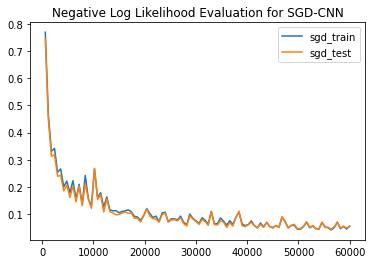

In [123]:
plt.plot(x, y_nll_sgd_train, label='sgd_train')
plt.plot(x, y_nll_sgd_test, label='sgd_test')
plt.title('Negative Log Likelihood Evaluation for SGD-CNN')
plt.legend();

In [124]:
y_acc_sgd_test = []
y_acc_sgd_train = []
for i, param in enumerate(tqdm(result_sgd[f'param_per_{params_interval}_batches'])):
    # Evaluate misclassification rate on test set
    y_acc_sgd_test.append(evaluate_accuracy(state_sgd, param, test_ds))

    # Evaluate misclassification rate on train set
    y_acc_sgd_train.append(evaluate_accuracy(state_sgd, param, train_ds))

100%|██████████| 100/100 [00:04<00:00, 20.84it/s]


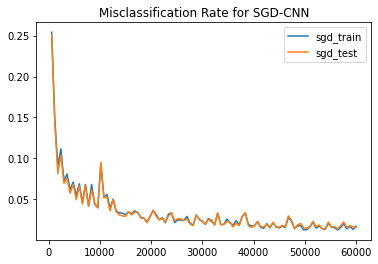

In [125]:
plt.plot(x, y_acc_sgd_train, label='sgd_train')
plt.plot(x, y_acc_sgd_test, label='sgd_test')
plt.title('Misclassification Rate for SGD-CNN')
plt.legend();

In [126]:
# Delete parameters from memory
del state_sgd, result_sgd

## 2.2 CNN - Polyak-averaged

In [115]:
state_sgd_polyak, result_sgd_polyak = train_and_evaluate_sgd(train_ds, config, polyak_averaging=True)

loss-scaled mean accuracy: 0.954; mean accuracy: 0.983: 100%|██████████| 60000/60000 [06:26<00:00, 155.28it/s]


In [116]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
y_nll_sgd_polyak_test = []
y_nll_sgd_polyak_train = []
for i, param in enumerate(tqdm(result_sgd_polyak[f'param_per_{params_interval}_batches'])):
    # Evaluate nll on test set
    y_nll_sgd_polyak_test.append(evaluate_neg_log_likelihood(state_sgd_polyak, param, test_ds))

    # Evaluate nll on train set
    y_nll_sgd_polyak_train.append(evaluate_neg_log_likelihood(state_sgd_polyak, param, train_ds))

100%|██████████| 100/100 [00:05<00:00, 19.46it/s]


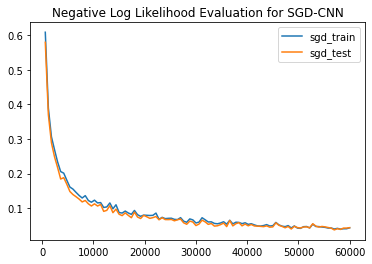

In [117]:
plt.plot(x, y_nll_sgd_train, label='sgd_train')
plt.plot(x, y_nll_sgd_test, label='sgd_test')
plt.title('Negative Log Likelihood Evaluation for SGD-CNN')
plt.legend();

In [118]:
y_acc_sgd_polyak_test = []
y_acc_sgd_polyak_train = []
for i, param in enumerate(tqdm(result_sgd_polyak[f'param_per_{params_interval}_batches'])):
    # Evaluate misclassification rate on test set
    y_acc_sgd_polyak_test.append(evaluate_accuracy(state_sgd_polyak, param, test_ds))

    # Evaluate misclassification rate on train set
    y_acc_sgd_polyak_train.append(evaluate_accuracy(state_sgd_polyak, param, train_ds))

100%|██████████| 100/100 [00:04<00:00, 20.90it/s]


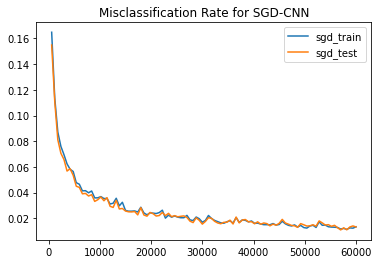

In [119]:
plt.plot(x, y_acc_sgd_train, label='sgd_train')
plt.plot(x, y_acc_sgd_test, label='sgd_test')
plt.title('Misclassification Rate for SGD-CNN')
plt.legend();

In [120]:
# Delete parameters from memory
del state_sgd_polyak, result_sgd_polyak

## 2.3 MLP

In [71]:
features = [25, 25, 25, 10]
state_sgd_mlp, result_sgd_mlp = train_and_evaluate_sgd(train_ds, config, train_with_MLP=True, features=features)

loss-scaled mean accuracy: 0.793; mean accuracy: 0.927: 100%|██████████| 60000/60000 [02:46<00:00, 360.82it/s]


In [72]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
y_nll_sgd_mlp_test = []
y_nll_sgd_mlp_train = []
for i, param in enumerate(tqdm(result_sgd_mlp[f'param_per_{params_interval}_batches'])):
    # Evaluate nll on test set
    y_nll_sgd_mlp_test.append(evaluate_neg_log_likelihood(state_sgd_mlp, param, test_ds))

    # Evaluate nll on train set
    y_nll_sgd_mlp_train.append(evaluate_neg_log_likelihood(state_sgd_mlp, param, train_ds))

100%|██████████| 100/100 [00:00<00:00, 138.13it/s]


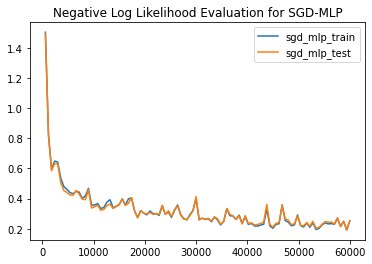

In [73]:
plt.plot(x, y_nll_sgd_mlp_train, label='sgd_mlp_train')
plt.plot(x, y_nll_sgd_mlp_test, label='sgd_mlp_test')
plt.title('Negative Log Likelihood Evaluation for SGD-MLP')
plt.legend();

In [74]:
y_acc_sgd_mlp_test = []
y_acc_sgd_mlp_train = []
for i, param in enumerate(tqdm(result_sgd_mlp[f'param_per_{params_interval}_batches'])):
    # Evaluate misclassification rate on test set
    y_acc_sgd_mlp_test.append(evaluate_accuracy(state_sgd_mlp, param, test_ds))

    # Evaluate misclassification rate on train set
    y_acc_sgd_mlp_train.append(evaluate_accuracy(state_sgd_mlp, param, train_ds))

100%|██████████| 100/100 [00:00<00:00, 171.20it/s]


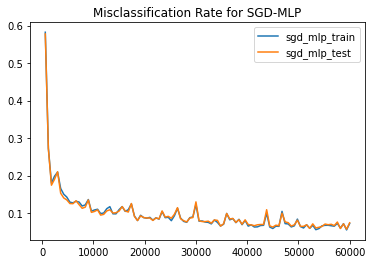

In [75]:
plt.plot(x, y_acc_sgd_mlp_train, label='sgd_mlp_train')
plt.plot(x, y_acc_sgd_mlp_test, label='sgd_mlp_test')
plt.title('Misclassification Rate for SGD-MLP')
plt.legend();

In [76]:
# Delete parameters from memory
del state_sgd_mlp, result_sgd_mlp

## 2.3 MLP - Polyak-averaged

In [77]:
features = [25, 25, 25, 10]
state_sgd_mlp_polyak, result_sgd_mlp_polyak = train_and_evaluate_sgd(train_ds, config, train_with_MLP=True, features=features, polyak_averaging=True)

loss-scaled mean accuracy: 0.793; mean accuracy: 0.927: 100%|██████████| 60000/60000 [04:31<00:00, 221.14it/s]


In [78]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
y_nll_sgd_mlp_polyak_test = []
y_nll_sgd_mlp_polyak_train = []
for i, param in enumerate(tqdm(result_sgd_mlp_polyak[f'param_per_{params_interval}_batches'])):
    # Evaluate nll on test set
    y_nll_sgd_mlp_polyak_test.append(evaluate_neg_log_likelihood(state_sgd_mlp_polyak, param, test_ds))

    # Evaluate nll on train set
    y_nll_sgd_mlp_polyak_train.append(evaluate_neg_log_likelihood(state_sgd_mlp_polyak, param, train_ds))

100%|██████████| 100/100 [00:00<00:00, 129.85it/s]


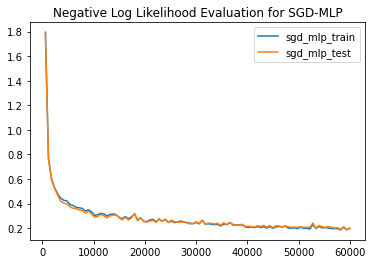

In [79]:
plt.plot(x, y_nll_sgd_mlp_polyak_train, label='sgd_mlp_train')
plt.plot(x, y_nll_sgd_mlp_polyak_test, label='sgd_mlp_test')
plt.title('Negative Log Likelihood Evaluation for SGD-MLP')
plt.legend();

In [80]:
y_acc_sgd_mlp_polyak_test = []
y_acc_sgd_mlp_polyak_train = []
for i, param in enumerate(tqdm(result_sgd_mlp_polyak[f'param_per_{params_interval}_batches'])):
    # Evaluate misclassification rate on test set
    y_acc_sgd_mlp_polyak_test.append(evaluate_accuracy(state_sgd_mlp_polyak, param, test_ds))

    # Evaluate misclassification rate on train set
    y_acc_sgd_mlp_polyak_train.append(evaluate_accuracy(state_sgd_mlp_polyak, param, train_ds))

100%|██████████| 100/100 [00:00<00:00, 239.95it/s]


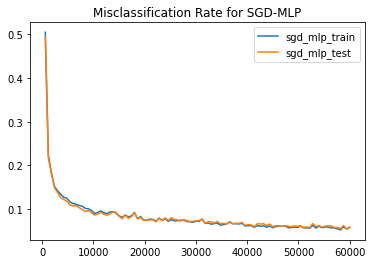

In [81]:
plt.plot(x, y_acc_sgd_mlp_polyak_train, label='sgd_mlp_train')
plt.plot(x, y_acc_sgd_mlp_polyak_test, label='sgd_mlp_test')
plt.title('Misclassification Rate for SGD-MLP')
plt.legend();

In [82]:
# Delete parameters from memory
del state_sgd_mlp_polyak, result_sgd_mlp_polyak

# 3. Full-Covariance EKF

In [20]:
features = [25, 25, 25, 10]
state_fcekf, state_fcekf_param, result_fcekf = train_and_evaluate_ekf(train_ds, test_ds, config, 'fcekf', train_with_MLP=True, features=features)

Params size = (21185,)


test_nll = 0.1903618574142456: 100%|██████████| 60000/60000 [12:36<00:00, 79.31it/s] 


In [83]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)

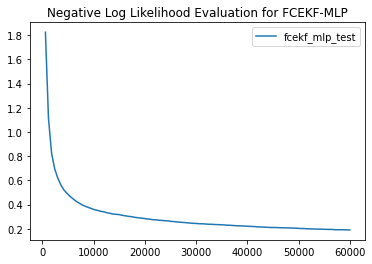

In [84]:
fig, ax = plt.subplots()
# ax.plot(x, result_fcekf[f'nll_train_per_{params_interval}_batches'], label='fcekf_mlp_train')
ax.plot(x, result_fcekf[f'nll_test_per_{params_interval}_batches'], label='fcekf_mlp_test')
ax.set_title('Negative Log Likelihood Evaluation for FCEKF-MLP')
ax.legend();

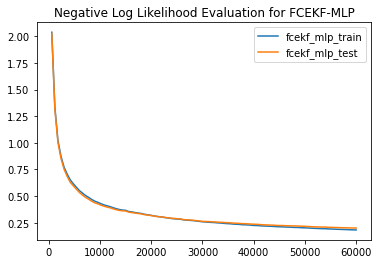

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fcekf[f'nll_train_per_{params_interval}_batches'], label='fcekf_mlp_train')
ax.plot(x, result_fcekf[f'nll_test_per_{params_interval}_batches'], label='fcekf_mlp_test')
ax.set_title('Negative Log Likelihood Evaluation for FCEKF-MLP')
ax.legend();

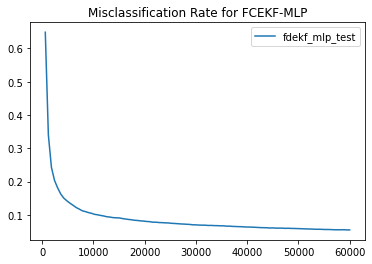

In [85]:
fig, ax = plt.subplots()
# ax.plot(x, result_fcekf[f'acc_train_per_{params_interval}_batches'], label='fdekf_mlp_train')
ax.plot(x, result_fcekf[f'acc_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.set_title('Misclassification Rate for FCEKF-MLP')
ax.legend();

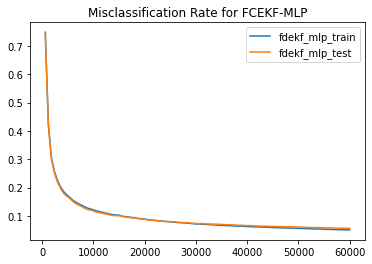

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fcekf[f'acc_train_per_{params_interval}_batches'], label='fdekf_mlp_train')
ax.plot(x, result_fcekf[f'acc_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.set_title('Misclassification Rate for FCEKF-MLP')
ax.legend();

# 4. FDEKF

## 4.1 CNN

In [128]:
state_fdekf_cnn, state_fdekf_param_cnn, result_fdekf_cnn = train_and_evaluate_ekf(train_ds, test_ds, config, 'fdekf', large_params=True)

XlaRuntimeError: ignored

In [ ]:
fig, ax = plt.subplots()
# ax.plot(x, result_fdekf_cnn[f'nll_train_per_{params_interval}_batches'], label='fdekf_cnn_train')
ax.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='fdekf_cnn_test')
ax.set_title('Negative Log Likelihood Evaluation for FDEKF-CNN')
ax.legend();

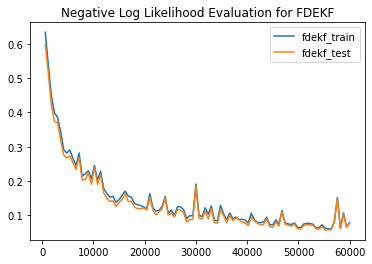

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_cnn[f'nll_train_per_{params_interval}_batches'], label='fdekf_cnn_train')
ax.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='fdekf_cnn_test')
ax.set_title('Negative Log Likelihood Evaluation for FDEKF-CNN')
ax.legend();

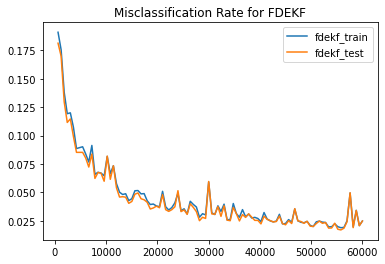

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_cnn[f'acc_train_per_{params_interval}_batches'], label='fdekf_cnn_train')
ax.plot(x, result_fdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='fdekf_cnn_test')
ax.set_title('Misclassification Rate for FDEKF-CNN')
ax.legend();

## 4.2 MLP

In [86]:
features = [25, 25, 25, 10]
state_fdekf_mlp, state_param_fdekf_mlp, result_fdekf_mlp = train_and_evaluate_ekf(train_ds, test_ds, config, 'fdekf', train_with_MLP=True, features=features)

Params size = (21185,)


test_nll = 0.19664523005485535: 100%|██████████| 60000/60000 [06:19<00:00, 158.18it/s]


In [87]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)

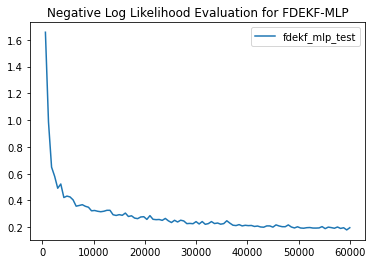

In [88]:
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.set_title('Negative Log Likelihood Evaluation for FDEKF-MLP')
ax.legend();

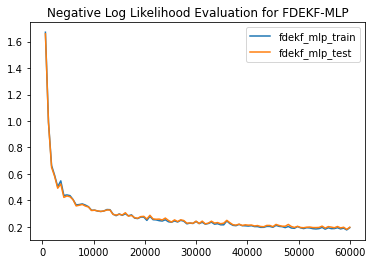

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_mlp[f'nll_train_per_{params_interval}_batches'], label='fdekf_mlp_train')
ax.plot(x, result_fdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.set_title('Negative Log Likelihood Evaluation for FDEKF-MLP')
ax.legend();

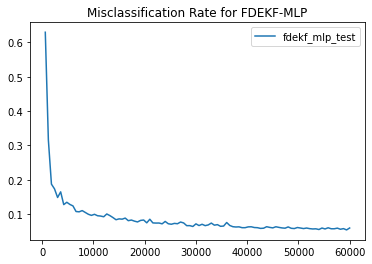

In [89]:
fig, ax = plt.subplots()
# ax.plot(x, result_fdekf_mlp[f'acc_train_per_{params_interval}_batches'], label='fdekf_mlp_train')
ax.plot(x, result_fdekf_mlp[f'acc_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.set_title('Misclassification Rate for FDEKF-MLP')
ax.legend();

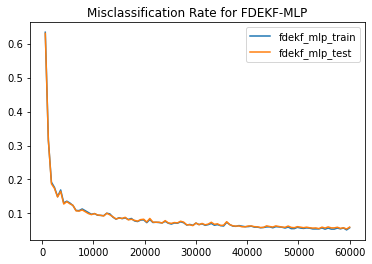

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_mlp[f'acc_train_per_{params_interval}_batches'], label='fdekf_mlp_train')
ax.plot(x, result_fdekf_mlp[f'acc_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.set_title('Misclassification Rate for FDEKF-MLP')
ax.legend();

# 6. VDEKF

## 6.1 CNN

In [ ]:
state_vdekf_cnn, state_vdekf_param_cnn, result_vdekf_cnn = train_and_evaluate_ekf(train_ds, test_ds, config, 'vdekf')

100%|██████████| 60000/60000 [04:38<00:00, 215.82it/s]


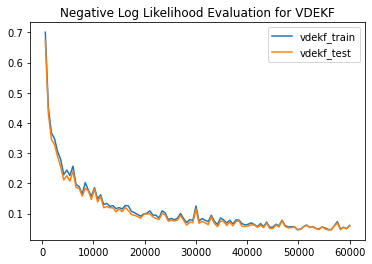

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_cnn[f'nll_train_per_{params_interval}_batches'], label='vdekf_cnn_train')
ax.plot(x, result_vdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='vdekf_cnn_test')
ax.set_title('Negative Log Likelihood Evaluation for VDEKF-CNN')
ax.legend();

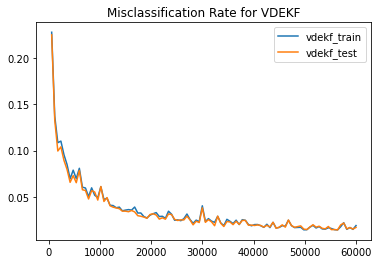

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_cnn[f'acc_train_per_{params_interval}_batches'], label='vdekf_cnn_train')
ax.plot(x, result_vdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='vdekf_cnn_test')
ax.set_title('Misclassification Rate for VDEKF-CNN')
ax.legend();

## 6.2 MLP

In [90]:
state_vdekf_mlp, state_param_vdekf_mlp, result_vdekf_mlp = train_and_evaluate_ekf(train_ds, test_ds, config, 'vdekf', train_with_MLP=True, features=features)

Params size = (21185,)


test_nll = 0.1918712556362152: 100%|██████████| 60000/60000 [06:16<00:00, 159.29it/s]


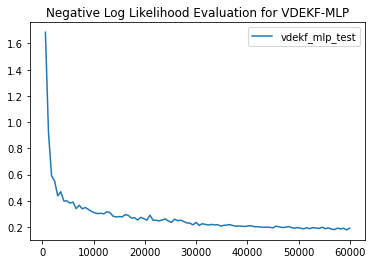

In [91]:
fig, ax = plt.subplots()
# ax.plot(x, result_vdekf_mlp[f'nll_train_per_{params_interval}_batches'], label='vdekf_mlp_train')
ax.plot(x, result_vdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Negative Log Likelihood Evaluation for VDEKF-MLP')
ax.legend();

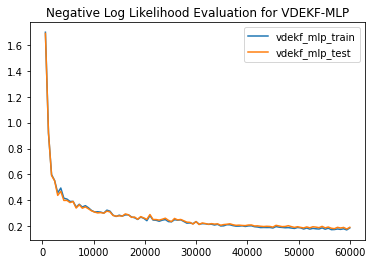

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_mlp[f'nll_train_per_{params_interval}_batches'], label='vdekf_mlp_train')
ax.plot(x, result_vdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Negative Log Likelihood Evaluation for VDEKF-MLP')
ax.legend();

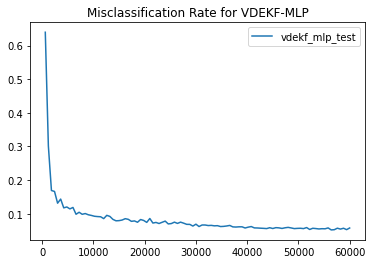

In [92]:
fig, ax = plt.subplots()
# ax.plot(x, result_vdekf_mlp[f'acc_train_per_{params_interval}_batches'], label='vdekf_mlp_train')
ax.plot(x, result_vdekf_mlp[f'acc_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Misclassification Rate for VDEKF-MLP')
ax.legend();

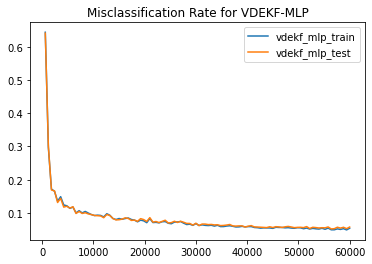

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_mlp[f'acc_train_per_{params_interval}_batches'], label='vdekf_mlp_train')
ax.plot(x, result_vdekf_mlp[f'acc_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Misclassification Rate for VDEKF-MLP')
ax.legend();

# 7. Model Efficiency Comparison

## 7.1 CNN: SGD vs FDEKF vs VDEKF

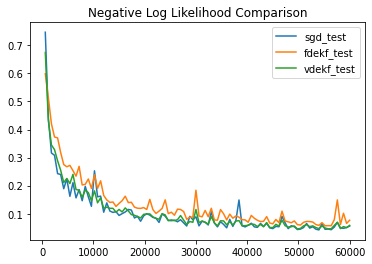

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_test, label='sgd_test')
ax.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='fdekf_test')
ax.plot(x, result_vdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='vdekf_test')
ax.set_title('Negative Log Likelihood Comparison')
ax.legend();
fig.savefig('nll_comparison.jpg')

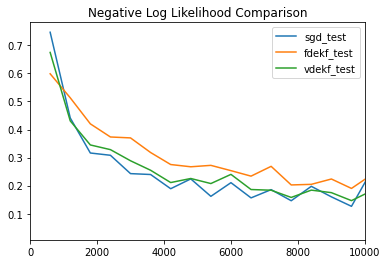

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_test, label='sgd_test')
ax.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='fdekf_test')
ax.plot(x, result_vdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='vdekf_test')
ax.set_title('Negative Log Likelihood Comparison')
ax.set_xlim(0, 10000)
ax.legend();
fig.savefig('nll_comparison_zoomed.jpg')

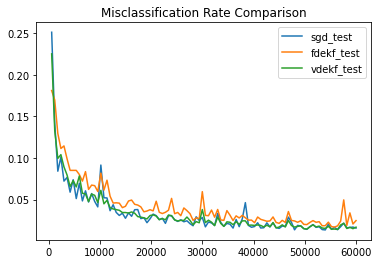

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_acc_sgd_test, label='sgd_test')
ax.plot(x, result_fdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='fdekf_test')
ax.plot(x, result_vdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='vdekf_test')
ax.set_title('Misclassification Rate Comparison')
ax.legend();
fig.savefig('acc_comparison.jpg')

## 7.2 MLP: SGD vs FCEKF vs FDEKF vs VDEKF

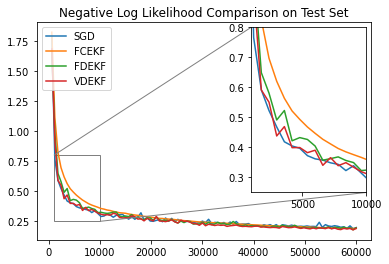

In [114]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_mlp_polyak_test, label='SGD')
ax.plot(x, result_fcekf[f'nll_test_per_{params_interval}_batches'], label='FCEKF')
ax.plot(x, result_fdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='FDEKF')
ax.plot(x, result_vdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='VDEKF')
ax.set_title('Negative Log Likelihood Comparison on Test Set')
ax.legend(loc=2);
axins = zoomed_inset_axes(ax, 2.5, loc=1)
axins.plot(x, y_nll_sgd_mlp_polyak_test, label='sgd_mlp_test')
axins.plot(x, result_fcekf[f'nll_test_per_{params_interval}_batches'], label='fcekf_mlp_test')
axins.plot(x, result_fdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
axins.plot(x, result_vdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
axins.set_xlim(1000, 10000)
axins.set_ylim(0.25, 0.8)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
fig.savefig('nll_comparison_mlp.jpg')

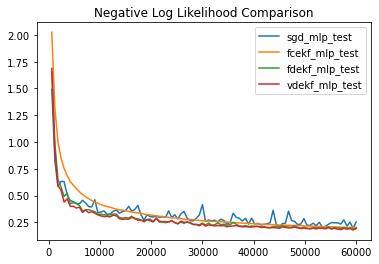

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_mlp_test, label='sgd_mlp_test')
ax.plot(x, result_fcekf[f'nll_test_per_{params_interval}_batches'], label='fcekf_mlp_test')
ax.plot(x, result_fdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.plot(x, result_vdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Negative Log Likelihood Comparison')
ax.legend();
fig.savefig('nll_comparison.jpg')

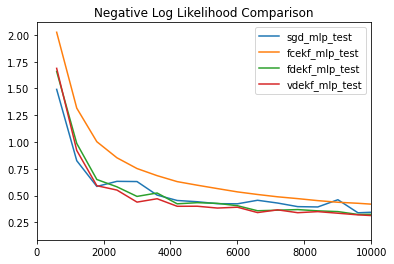

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_mlp_test, label='sgd_mlp_test')
ax.plot(x, result_fcekf[f'nll_test_per_{params_interval}_batches'], label='fcekf_mlp_test')
ax.plot(x, result_fdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.plot(x, result_vdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Negative Log Likelihood Comparison')
ax.set_xlim(0, 10000)
ax.legend();
fig.savefig('nll_comparison_zoomed.jpg')

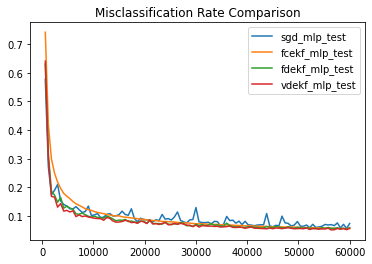

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_acc_sgd_mlp_test, label='sgd_mlp_test')
ax.plot(x, result_fcekf[f'acc_test_per_{params_interval}_batches'], label='fcekf_mlp_test')
ax.plot(x, result_fdekf_mlp[f'acc_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.plot(x, result_vdekf_mlp[f'acc_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Misclassification Rate Comparison')
ax.legend();
fig.savefig('acc_comparison.jpg')

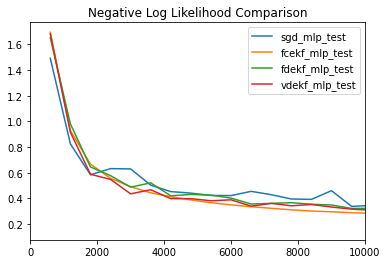

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_mlp_test, label='sgd_mlp_test')
ax.plot(x, y_nll_fcekf_test, label='fcekf_mlp_test')
ax.plot(x, y_nll_fdekf_mlp_test, label='fdekf_mlp_test')
ax.plot(x, y_nll_vdekf_mlp_test, label='vdekf_mlp_test')
ax.set_title('Negative Log Likelihood Comparison')
ax.set_xlim(0, 10000)
ax.legend();
fig.savefig('nll_comparison.jpg')

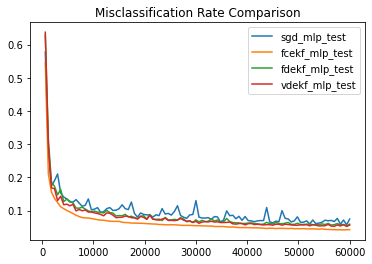

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_acc_sgd_mlp_test, label='sgd_mlp_test')
ax.plot(x, y_acc_fcekf_test, label='fcekf_mlp_test')
ax.plot(x, y_acc_fdekf_mlp_test, label='fdekf_mlp_test')
ax.plot(x, y_acc_vdekf_mlp_test, label='vdekf_mlp_test')
ax.set_title('Misclassification Rate Comparison')
ax.legend();
fig.savefig('acc_comparison.jpg')

# 8. Fashion-MNIST

In [ ]:
def get_fashion_mnist_datasets():
    """Load Fashion-MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('fashion_mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    train_ds['image'] = jnp.float32(train_ds['image']) / 255.
    test_ds['image'] = jnp.float32(test_ds['image']) / 255.
    return train_ds, test_ds
    
train_ds_fashion, test_ds_fashion = get_fashion_mnist_datasets()

## 8.1 SGD

In [ ]:
# SGD
state_sgd_fashion, result_sgd_fashion = train_and_evaluate_sgd(train_ds_fashion, config)

loss-scaled mean accuracy: 0.772; mean accuracy: 0.913: 100%|██████████| 60000/60000 [03:00<00:00, 331.93it/s]


In [ ]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
y_nll_sgd_fashion_test = []
y_nll_sgd_fashion_train = []
for i, param in enumerate(tqdm(result_sgd_fashion[f'param_per_{params_interval}_batches'])):
    # Evaluate nll on test set
    y_nll_sgd_fashion_test.append(evaluate_neg_log_likelihood(state_sgd_fashion, param, test_ds_fashion))

    # Evaluate nll on train set
    y_nll_sgd_fashion_train.append(evaluate_neg_log_likelihood(state_sgd_fashion, param, train_ds_fashion))

100%|██████████| 100/100 [00:05<00:00, 18.36it/s]


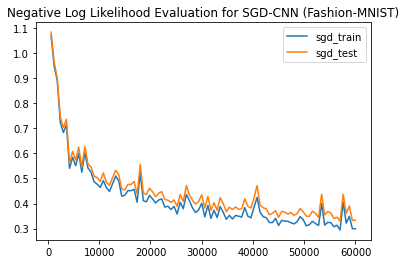

In [ ]:
plt.plot(x, y_nll_sgd_fashion_train, label='sgd_train')
plt.plot(x, y_nll_sgd_fashion_test, label='sgd_test')
plt.title('Negative Log Likelihood Evaluation for SGD-CNN (Fashion-MNIST)')
plt.legend();

In [ ]:
y_acc_sgd_fashion_test = []
y_acc_sgd_fashion_train = []
for i, param in enumerate(tqdm(result_sgd_fashion[f'param_per_{params_interval}_batches'])):
    # Evaluate misclassification rate on test set
    y_acc_sgd_fashion_test.append(evaluate_accuracy(state_sgd_fashion, param, test_ds_fashion))

    # Evaluate misclassification rate on train set
    y_acc_sgd_fashion_train.append(evaluate_accuracy(state_sgd_fashion, param, train_ds_fashion))

100%|██████████| 100/100 [00:04<00:00, 20.19it/s]


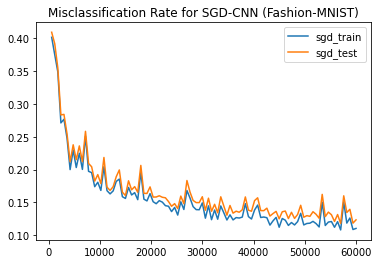

In [ ]:
plt.plot(x, y_acc_sgd_fashion_train, label='sgd_train')
plt.plot(x, y_acc_sgd_fashion_test, label='sgd_test')
plt.title('Misclassification Rate for SGD-CNN (Fashion-MNIST)')
plt.legend();

In [ ]:
# Delete parameters from memory
del state_sgd_fashion, result_sgd_fashion

## 8.2 FDEKF

In [ ]:
state_fdekf_cnn_fashion, state_fdekf_param_cnn_fashion, result_fdekf_cnn_fashion = train_and_evaluate_ekf(train_ds_fashion, test_ds_fashion, config, 'fdekf', large_params=True)

Params size = (421642,)


test_nll = 0.3659016788005829: 100%|██████████| 60000/60000 [22:26<00:00, 44.58it/s] 


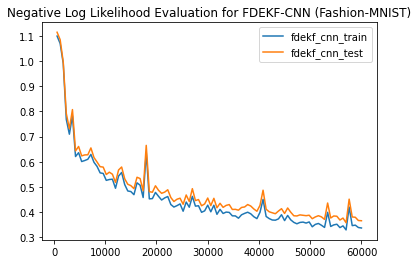

In [ ]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_cnn_fashion[f'nll_train_per_{params_interval}_batches'], label='fdekf_cnn_train')
ax.plot(x, result_fdekf_cnn_fashion[f'nll_test_per_{params_interval}_batches'], label='fdekf_cnn_test')
ax.set_title('Negative Log Likelihood Evaluation for FDEKF-CNN (Fashion-MNIST)')
ax.legend();

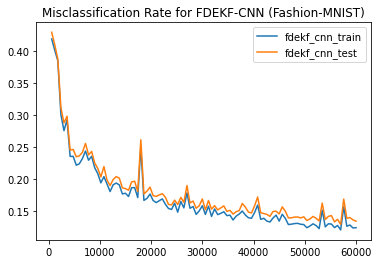

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_cnn_fashion[f'acc_train_per_{params_interval}_batches'], label='fdekf_cnn_train')
ax.plot(x, result_fdekf_cnn_fashion[f'acc_test_per_{params_interval}_batches'], label='fdekf_cnn_test')
ax.set_title('Misclassification Rate for FDEKF-CNN (Fashion-MNIST)')
ax.legend();

## 8.3 VDEKF

In [ ]:
state_vdekf_cnn_fashion, state_vdekf_param_cnn_fashion, result_vdekf_cnn_fashion = train_and_evaluate_ekf(train_ds_fashion, test_ds_fashion, config, 'vdekf', large_params=True)

Params size = (421642,)


test_nll = 0.34664955735206604: 100%|██████████| 60000/60000 [22:18<00:00, 44.83it/s] 


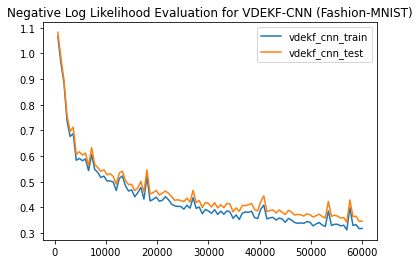

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_cnn_fashion[f'nll_train_per_{params_interval}_batches'], label='vdekf_cnn_train')
ax.plot(x, result_vdekf_cnn_fashion[f'nll_test_per_{params_interval}_batches'], label='vdekf_cnn_test')
ax.set_title('Negative Log Likelihood Evaluation for VDEKF-CNN (Fashion-MNIST)')
ax.legend();

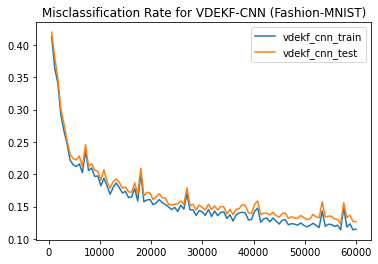

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_cnn_fashion[f'acc_train_per_{params_interval}_batches'], label='vdekf_cnn_train')
ax.plot(x, result_vdekf_cnn_fashion[f'acc_test_per_{params_interval}_batches'], label='vdekf_cnn_test')
ax.set_title('Misclassification Rate for VDEKF-CNN (Fashion-MNIST)')
ax.legend();

## 8.4 Model Comparison (SGD vs FDEKF vs VDEKF)

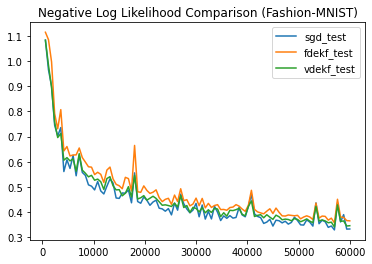

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_fashion_test, label='sgd_test')
ax.plot(x, result_fdekf_cnn_fashion[f'nll_test_per_{params_interval}_batches'], label='fdekf_test')
ax.plot(x, result_vdekf_cnn_fashion[f'nll_test_per_{params_interval}_batches'], label='vdekf_test')
ax.set_title('Negative Log Likelihood Comparison (Fashion-MNIST)')
ax.legend();
fig.savefig('nll_comparison_fmnist.jpg')

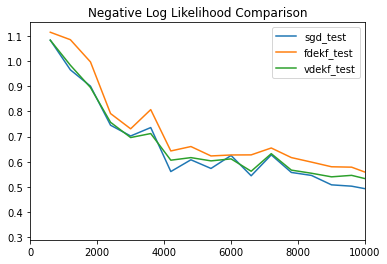

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_fashion_test, label='sgd_test')
ax.plot(x, result_fdekf_cnn_fashion[f'nll_test_per_{params_interval}_batches'], label='fdekf_test')
ax.plot(x, result_vdekf_cnn_fashion[f'nll_test_per_{params_interval}_batches'], label='vdekf_test')
ax.set_title('Negative Log Likelihood Comparison')
ax.set_xlim(0, 10000)
ax.legend();
fig.savefig('nll_comparison_zoomed_fmnist.jpg')

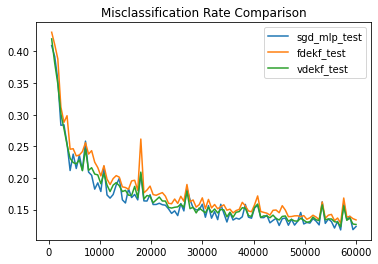

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_acc_sgd_fashion_test, label='sgd_mlp_test')
ax.plot(x, result_fdekf_cnn_fashion[f'acc_test_per_{params_interval}_batches'], label='fdekf_test')
ax.plot(x, result_vdekf_cnn_fashion[f'acc_test_per_{params_interval}_batches'], label='vdekf_test')
ax.set_title('Misclassification Rate Comparison')
ax.legend();
fig.savefig('acc_comparison_fmnist.jpg')